In [2]:
# ----------------------------
# 1. Importar librerías
# ----------------------------
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [3]:
pip install openpyxl


Note: you may need to restart the kernel to use updated packages.


In [4]:
import openpyxl

In [5]:
# ----------------------------
# 2. Cargar archivos
# ----------------------------
# tb_productos
tb_productos = pd.read_excel('C:/Users/juans/Documents/MCD/1-materias/laboratorio III/TP_final/data/tb_productos.xlsx')

# tb_stock
tb_stock = pd.read_excel("C:/Users/juans/Documents/MCD/1-materias/laboratorio III/TP_final/data/tb_stock.xlsx")

# product_id_apredecir201912
productos_apredecir = pd.read_excel("C:/Users/juans/Documents/MCD/1-materias/laboratorio III/TP_final/data/product_id_apredecir201912.xlsx")

# sell-in.txt en chunks
chunksize = 10 ** 6
sell_in_chunks = pd.read_csv("C:/Users/juans/Documents/MCD/1-materias/laboratorio III/TP_final/data/sell-in.txt", delimiter='\t', chunksize=chunksize)

# Procesar sell-in por chunks y filtrar columnas necesarias
sell_in_list = []
for chunk in sell_in_chunks:
    df_chunk = chunk
    # df_chunk = chunk[['periodo', 'product_id', 'tn']]
    sell_in_list.append(df_chunk)

sell_in = pd.concat(sell_in_list)


In [6]:

# ----------------------------
# 3. Generar features de lags y target
# ----------------------------
# Agrupar ventas por periodo y producto
ventas_agg = sell_in.groupby(['periodo', 'product_id'], as_index=False)['tn'].sum()
ventas_agg = ventas_agg.sort_values(['product_id', 'periodo'])

# Crear lags t-1, t-2, t-3
ventas_agg['lag_tn_1'] = ventas_agg.groupby('product_id')['tn'].shift(1)
ventas_agg['lag_tn_2'] = ventas_agg.groupby('product_id')['tn'].shift(2)
ventas_agg['lag_tn_3'] = ventas_agg.groupby('product_id')['tn'].shift(3)

# Crear target mes +2
ventas_agg['target_tn_mes_plus2'] = ventas_agg.groupby('product_id')['tn'].shift(-2)


In [7]:
ventas_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31243 entries, 0 to 6437
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   periodo              31243 non-null  int64  
 1   product_id           31243 non-null  int64  
 2   tn                   31243 non-null  float64
 3   lag_tn_1             30010 non-null  float64
 4   lag_tn_2             28797 non-null  float64
 5   lag_tn_3             27595 non-null  float64
 6   target_tn_mes_plus2  28797 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 1.9 MB


In [8]:

# ----------------------------
# 4. Merge con stock y atributos
# ----------------------------
dataset = pd.merge(ventas_agg, tb_stock, how='left', on=['periodo', 'product_id'])
dataset = pd.merge(dataset, tb_productos, how='left', on='product_id')


In [9]:
# ✅ Crear features avanzadas de series de tiempo por product_id en tu dataset

# Ordenar el dataset por product_id y periodo antes de crear rolling y shifts
dataset = dataset.sort_values(['product_id', 'periodo']).reset_index(drop=True)

# 🔧 1. Medias móviles simples (SMA)
dataset['sma_3'] = dataset.groupby('product_id')['tn'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
dataset['sma_7'] = dataset.groupby('product_id')['tn'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
dataset['sma_14'] = dataset.groupby('product_id')['tn'].transform(lambda x: x.rolling(window=14, min_periods=1).mean())

# 🔧 2. Medias móviles exponenciales (EMA)
dataset['ema_3'] = dataset.groupby('product_id')['tn'].transform(lambda x: x.ewm(span=3, adjust=False).mean())
dataset['ema_7'] = dataset.groupby('product_id')['tn'].transform(lambda x: x.ewm(span=7, adjust=False).mean())

# 🔧 3. Diferencias (Diff)
dataset['diff_1'] = dataset.groupby('product_id')['tn'].transform(lambda x: x.diff(1))
dataset['diff_7'] = dataset.groupby('product_id')['tn'].transform(lambda x: x.diff(7))

# 🔧 4. Desviación estándar móvil (Volatilidad)
dataset['rolling_std_7'] = dataset.groupby('product_id')['tn'].transform(lambda x: x.rolling(window=7, min_periods=1).std())
dataset['rolling_std_14'] = dataset.groupby('product_id')['tn'].transform(lambda x: x.rolling(window=14, min_periods=1).std())

# 🔧 5. Lags adicionales
dataset['lag_7'] = dataset.groupby('product_id')['tn'].transform(lambda x: x.shift(7))
dataset['lag_14'] = dataset.groupby('product_id')['tn'].transform(lambda x: x.shift(14))

# 🔧 6. Tendencia (diferencia de medias móviles)
dataset['trend_7_14'] = dataset['sma_7'] - dataset['sma_14']

# 🔧 7. Ratio (ejemplo stock_final / tn)
if 'stock_final' in dataset.columns:
    dataset['stock_ratio'] = dataset['stock_final'] / (dataset['tn'] + 1)  # +1 para evitar división por cero

# 🔧 8. Limpieza de NaN generados por rolling y shift (opcional)
dataset = dataset.fillna(0)


dataset.head()


,periodo,product_id,tn,lag_tn_1,lag_tn_2,lag_tn_3,target_tn_mes_plus2,stock_final,cat1,cat2,...,ema_3,ema_7,diff_1,diff_7,rolling_std_7,rolling_std_14,lag_7,lag_14,trend_7_14,stock_ratio
0,201701,20001,934.77222,0.00000,0.00000,0.00000,1303.35771,0.0,HC,ROPA LAVADO,...,934.772220,934.772220,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,201702,20001,798.01620,934.77222,0.00000,0.00000,1069.96130,0.0,HC,ROPA LAVADO,...,866.394210,900.583215,-136.75602,0.0,96.701109,96.701109,0.0,0.0,0.0,0.0
2,201703,20001,1303.35771,798.01620,934.77222,0.00000,1502.20132,0.0,HC,ROPA LAVADO,...,1084.875960,1001.276839,505.34151,0.0,261.383344,261.383344,0.0,0.0,0.0,0.0
3,201704,20001,1069.96130,1303.35771,798.01620,934.77222,1520.06539,0.0,HC,ROPA LAVADO,...,1077.418630,1018.447954,-233.39641,0.0,215.374020,215.374020,0.0,0.0,0.0,0.0
4,201705,20001,1502.20132,1069.96130,1303.35771,798.01620,1030.67391,0.0,HC,ROPA LAVADO,...,1289.809975,1139.386296,432.24002,0.0,282.918213,282.918213,0.0,0.0,0.0,0.0


In [10]:

# ----------------------------
# 5. Limpiar dataset
# ----------------------------
# Reemplazo de NaN en lags y stock_final
dataset[['lag_tn_1', 'lag_tn_2', 'lag_tn_3']] = dataset[['lag_tn_1', 'lag_tn_2', 'lag_tn_3']].fillna(0)
dataset['stock_final'] = dataset['stock_final'].fillna(0)


In [11]:

# Reemplazo NaN en atributos
for col in ['cat1', 'cat2', 'cat3', 'brand']:
    dataset[col] = dataset[col].fillna('Unknown')
dataset['sku_size'] = dataset['sku_size'].fillna(dataset['sku_size'].median())

# Eliminar filas sin target (para entrenamiento)
dataset_train = dataset.dropna(subset=['target_tn_mes_plus2'])


In [12]:
# ----------------------------
# 6. Preparar X e y
# ----------------------------
X = dataset_train.drop(columns=['target_tn_mes_plus2', 'periodo', 'product_id', 'tn'])
y = dataset_train['target_tn_mes_plus2']

# Convertir variables categóricas a category
to_category = ['cat1', 'cat2', 'cat3', 'brand']
for col in to_category:
    X[col] = X[col].astype('category')


In [13]:
# ----------------------------
# 7. Entrenamiento LightGBM
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[466]	training's rmse: 21.5903	valid_1's rmse: 3.14927


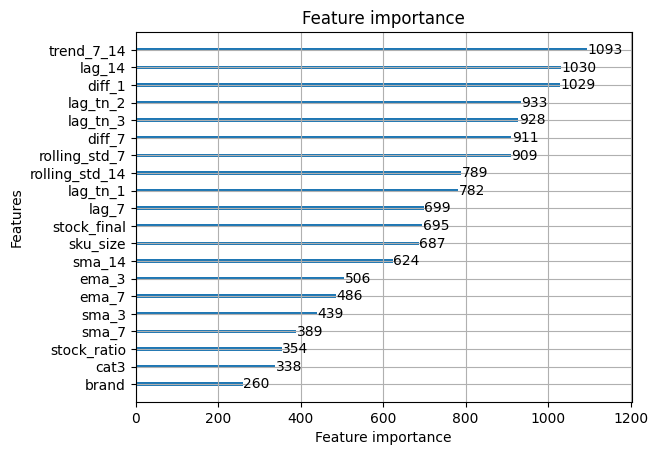

In [14]:
# ----------------------------
# 8. Importancia de variables
# ----------------------------
lgb.plot_importance(model, max_num_features=20)
plt.show()


In [15]:
# ----------------------------
# 9. Preparar features para predicción mes +2 (202002)
# ----------------------------
# Filtrar dataset para periodo 201912 y los productos a predecir
pred_df = dataset[dataset['periodo'] == 201912]
pred_df = pred_df[pred_df['product_id'].isin(productos_apredecir['product_id'])]

# Seleccionar X_pred con las mismas columnas de X_train
X_pred = pred_df[X.columns]

# Convertir variables categóricas a category
for col in to_category:
    X_pred[col] = X_pred[col].astype('category')



C:\Users\juans\AppData\Local\Temp\ipykernel_25224\461970376.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_pred[col] = X_pred[col].astype('category')
C:\Users\juans\AppData\Local\Temp\ipykernel_25224\461970376.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_pred[col] = X_pred[col].astype('category')
C:\Users\juans\AppData\Local\Temp\ipykernel_25224\461970376.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [16]:
# ----------------------------
# 10. Generar predicciones y exportar submission
# ----------------------------
y_pred = model.predict(X_pred, num_iteration=model.best_iteration)

submission = pd.DataFrame({
    'product_id': pred_df['product_id'].values,
    'tn': y_pred
})

# Agrupar para asegurar 1 fila por producto
submission = submission.groupby('product_id', as_index=False)['tn'].sum()

# Guardar como CSV
submission.to_csv('submission_kaggle.csv', index=False)
print("✅ Archivo submission_kaggle.csv generado con", submission.shape[0], "filas.")



✅ Archivo submission_kaggle.csv generado con 780 filas.
